In [28]:
# community_analysis.ipynb

# 📌 SECTION 1: IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [29]:
# 📌 SECTION 2: LOAD DATA
base_path = "../data/full"
# algo = "reverse_hybrid"
algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [30]:
# 📌 SECTION 3: MERGE COMMUNITY ASSIGNMENTS
merged_df = pd.merge(patient_df, community_df, on='patientId', how='inner')

# Optional: Label community types if needed
# community_df['communityType'] = community_df['nodeId'].apply(...)  # if SLPA vs Leiden tags exist

## Analysis

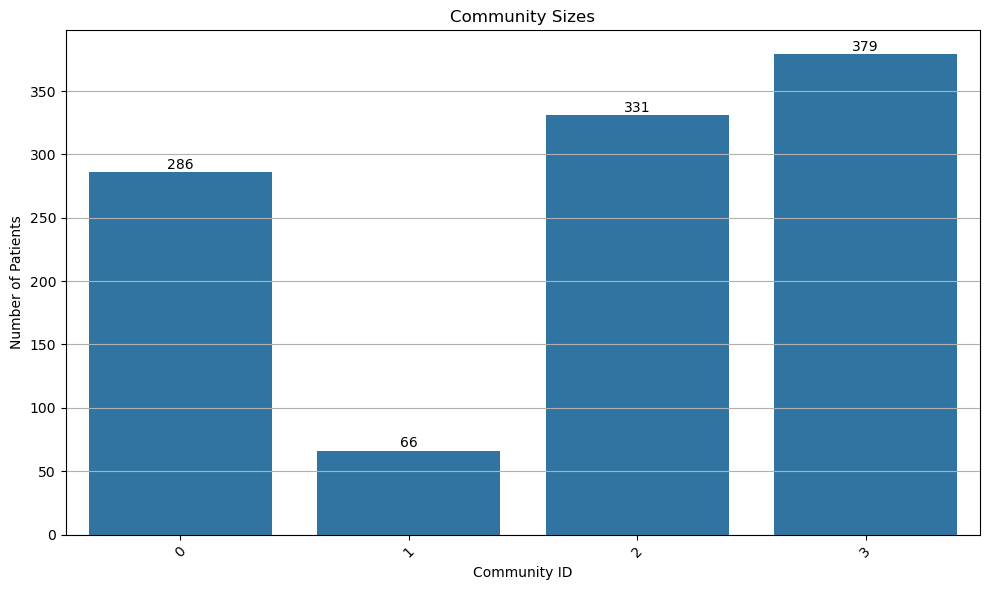

In [31]:
# plot community sizes
def plot_community_sizes(community_df):
    community_counts = community_df['communityId'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=community_counts.index, y=community_counts.values)
    plt.title("Community Sizes")
    plt.xlabel("Community ID")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45)
    # annotate count on bars
    for i, count in enumerate(community_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_community_sizes(community_df)

In [32]:
from collections import defaultdict

def print_overlapping_nodes(community_df):
    """
    Prints patientIds that belong to multiple communities and their memberships.
    """
    patient_to_comms = defaultdict(set)
    for _, row in community_df.iterrows():
        patient_to_comms[row['patientId']].add(row['communityId'])
    overlapping = {pid: list(comms) for pid, comms in patient_to_comms.items() if len(comms) > 1}
    print(f"Number of overlapping patients: {len(overlapping)}")
    if overlapping:
        print("Overlapping patients and their community memberships:")
        for pid, comms in overlapping.items():
            print(f"  PatientId: {pid} -> Communities: {sorted(comms)}")
    else:
        print("No overlapping patients found.")

# Call the function
print_overlapping_nodes(community_df)

Number of overlapping patients: 54
Overlapping patients and their community memberships:
  PatientId: P-CRC-0004 -> Communities: [1, 2]
  PatientId: P-CRC-0008 -> Communities: [1, 2]
  PatientId: P-CRC-0010 -> Communities: [1, 2]
  PatientId: P-CRC-0012 -> Communities: [1, 2]
  PatientId: P-CRC-0013 -> Communities: [1, 2]
  PatientId: P-CRC-0014 -> Communities: [1, 2]
  PatientId: P-DFCI-5027 -> Communities: [1, 2]
  PatientId: P-DFCI-5035 -> Communities: [1, 2]
  PatientId: P-DFCI-5049 -> Communities: [1, 2]
  PatientId: P-DFCI-5066 -> Communities: [1, 2]
  PatientId: P-DFCI-5068 -> Communities: [1, 2]
  PatientId: P-DFCI-5075 -> Communities: [1, 2]
  PatientId: P-DFCI-5095 -> Communities: [1, 2]
  PatientId: P-DFCI-5098 -> Communities: [1, 2]
  PatientId: P-DFCI-5105 -> Communities: [1, 2]
  PatientId: P-DFCI-5115 -> Communities: [1, 2]
  PatientId: P-DFCI-5129 -> Communities: [1, 2]
  PatientId: P-DFCI-5139 -> Communities: [1, 2]
  PatientId: P-DFCI-5143 -> Communities: [1, 2]
  Pat

In [33]:
# 📌 SECTION 4: COMMUNITY DEMOGRAPHIC ANALYSIS
def demographic_summary(df, groupby='communityId'):
    print("🔍 Age, Sex distribution per community:\n")
    print(df.groupby(groupby)['AGE_SAMPLING'].describe())
    print("\n🔹 Sex distribution:\n")
    print(pd.crosstab(df[groupby], df['SEX'], normalize='index'))

    sns.boxplot(data=df, x=groupby, y='AGE_SAMPLING')
    plt.title("Age Distribution per Community")
    plt.show()

    sns.countplot(data=df, x=groupby, hue='SEX')
    plt.title("Sex Distribution per Community")
    plt.show()

🔍 Age, Sex distribution per community:

             count       mean        std   min   25%   50%    75%   max
communityId                                                            
0            286.0  66.234266  11.698749  35.0  59.0  66.0  75.00  94.0
1             66.0  60.272727   9.748444  37.0  54.0  60.5  66.75  84.0
2            331.0  61.135952  10.761447  19.0  54.0  62.0  68.50  86.0
3            379.0  62.796834  11.437819  31.0  55.0  64.0  70.00  92.0

🔹 Sex distribution:

SEX            Female      Male
communityId                    
0            0.286713  0.713287
1            0.363636  0.636364
2            0.335347  0.664653
3            0.416887  0.583113


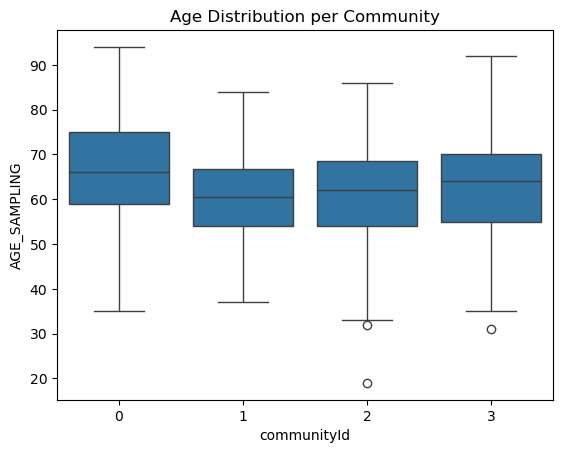

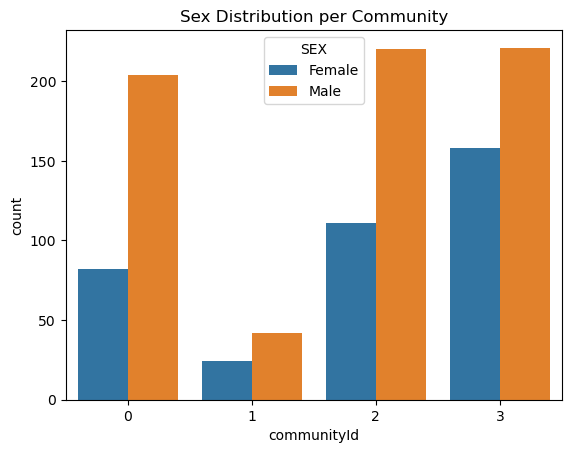

In [34]:
demographic_summary(merged_df)

In [35]:
# 📌 SECTION 5: CLINICAL ATTRIBUTE ANALYSIS
def clinical_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(pd.crosstab(df[groupby], df[feat], normalize='index'))

        sns.countplot(data=df, x=groupby, hue=feat)
        plt.title(f"{feat} per Community")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


🔬 CLL_EPITYPE distribution per community:

CLL_EPITYPE     i-CLL     m-CLL     n-CLL  unclassified
communityId                                            
0            0.101399  0.223776  0.580420      0.094406
1            0.106061  0.272727  0.287879      0.333333
2            0.154079  0.232628  0.465257      0.148036
3            0.155673  0.525066  0.171504      0.147757


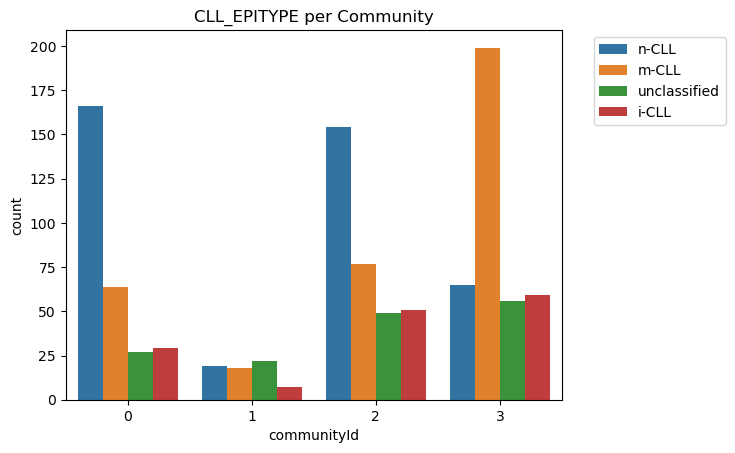


🔬 TUMOR_MOLECULAR_SUBTYPE distribution per community:

TUMOR_MOLECULAR_SUBTYPE     M-CLL     U-CLL
communityId                                
0                        0.478088  0.521912
1                        0.704918  0.295082
2                        0.552542  0.447458
3                        0.551613  0.448387


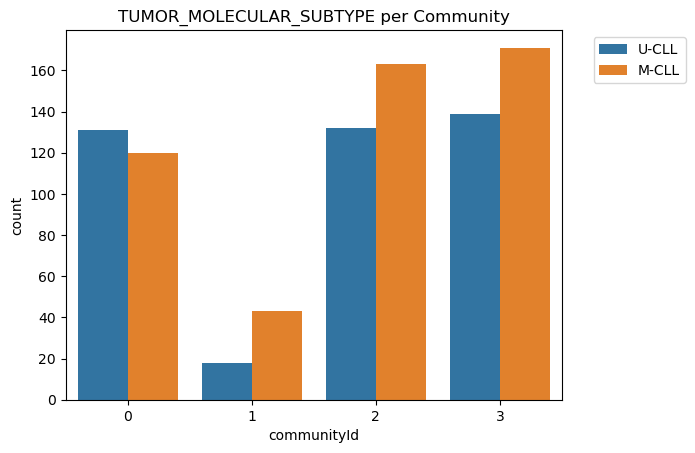


🔬 PRIOR_TREATMENT_CATEGORY distribution per community:

PRIOR_TREATMENT_CATEGORY  Ab + no Chemo  Chemo + Ab  Chemo + no Ab  LEN + Ab  \
communityId                                                                    
0                              0.003497    0.052448       0.038462  0.000000   
1                              0.000000    0.000000       0.030303  0.000000   
2                              0.003021    0.036254       0.018127  0.003021   
3                              0.002639    0.026385       0.021108  0.000000   

PRIOR_TREATMENT_CATEGORY   Rel/Ref  Untreated  
communityId                                    
0                         0.020979   0.884615  
1                         0.000000   0.969697  
2                         0.036254   0.903323  
3                         0.010554   0.939314  


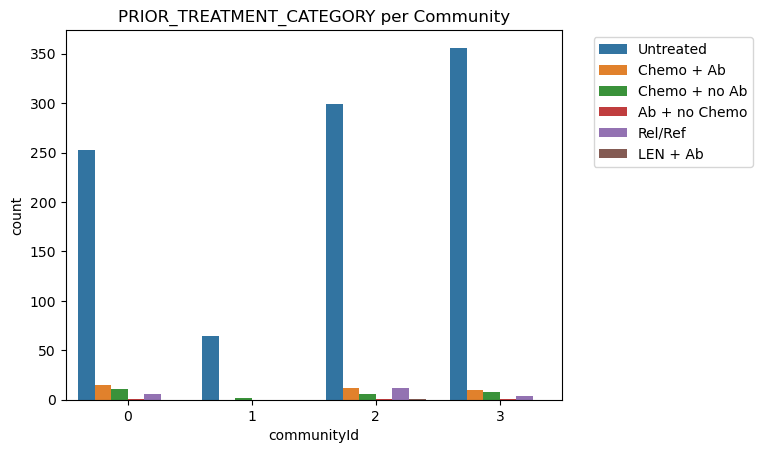


🔬 TREATMENT_AFTER_SAMPLING distribution per community:

TREATMENT_AFTER_SAMPLING  Ab + no chemo  BCL2 + Ab  BCL2 + BTK  BCL2 + chemo  \
communityId                                                                    
0                              0.067164   0.000000    0.000000      0.007463   
1                              0.030769   0.000000    0.000000      0.000000   
2                              0.043011   0.005376    0.005376      0.005376   
3                              0.062500   0.000000    0.000000      0.031250   

TREATMENT_AFTER_SAMPLING  BCL2 inhibitor  BTK + chemo + Ab  BTK inhibitor  \
communityId                                                                 
0                               0.007463          0.000000       0.007463   
1                               0.000000          0.000000       0.000000   
2                               0.005376          0.010753       0.069892   
3                               0.000000          0.000000       0.062500   


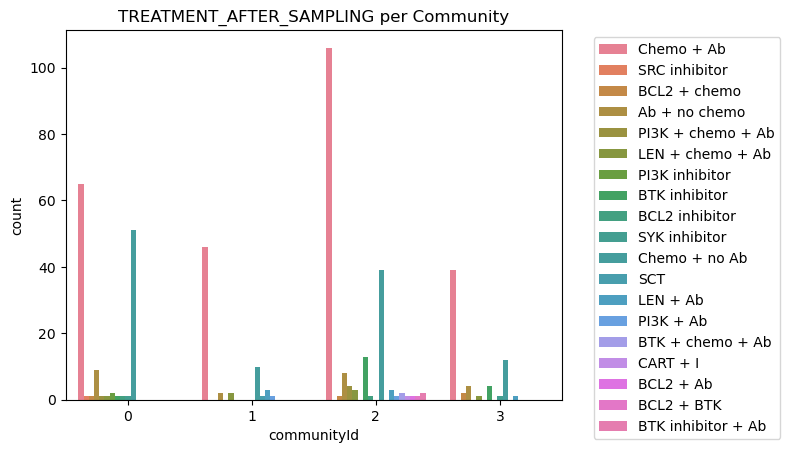

In [36]:
clinical_features = ['CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'PRIOR_TREATMENT_CATEGORY', 'TREATMENT_AFTER_SAMPLING']
clinical_summary(merged_df, clinical_features)


🔬 IGLV3_21_R110 distribution per community:

IGLV3_21_R110        No       Yes
communityId                      
0              0.881720  0.118280
1              0.923077  0.076923
2              0.897833  0.102167
3              0.905149  0.094851


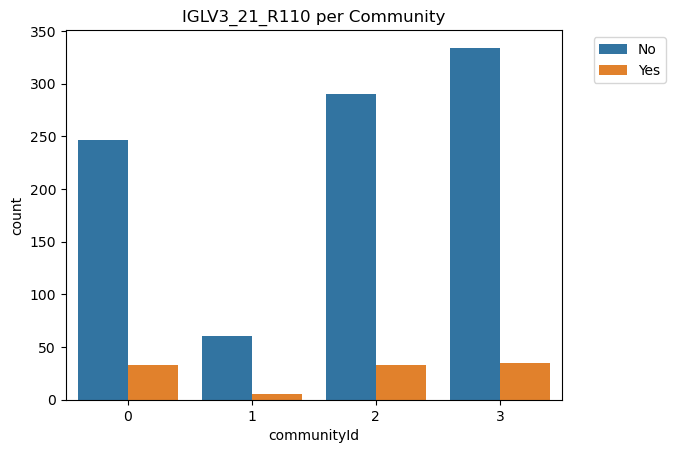


🔬 U1_STATUS distribution per community:

U1_STATUS         MUT        WT
communityId                    
0            0.031111  0.968889
1            0.033333  0.966667
2            0.038328  0.961672
3            0.034364  0.965636


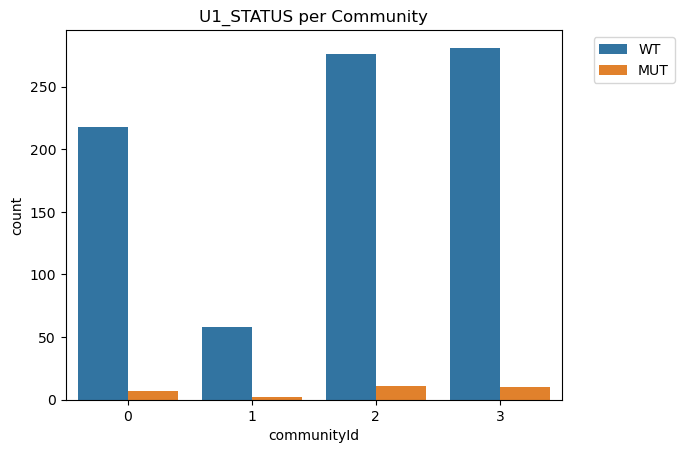


🔬 EXPRESSION_CLUSTER distribution per community:

EXPRESSION_CLUSTER         0      2258      EC-i     EC-m1     EC-m2  \
communityId                                                            
0                   0.402098  0.003497  0.059441  0.041958  0.045455   
1                   0.363636  0.000000  0.121212  0.045455  0.060606   
2                   0.474320  0.000000  0.084592  0.042296  0.039275   
3                   0.437995  0.000000  0.031662  0.063325  0.050132   

EXPRESSION_CLUSTER     EC-m3     EC-m4      EC-o     EC-u1     EC-u2  
communityId                                                           
0                   0.020979  0.066434  0.000000  0.272727  0.087413  
1                   0.045455  0.090909  0.000000  0.227273  0.045455  
2                   0.015106  0.084592  0.009063  0.181269  0.069486  
3                   0.105541  0.163588  0.044855  0.076517  0.026385  


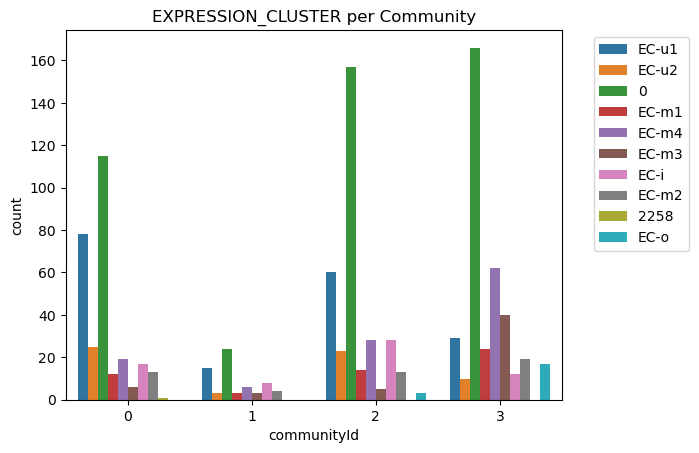


🔬 IGHV_MUTATION_STATUS distribution per community:

IGHV_MUTATION_STATUS   mutated  unmutated
communityId                              
0                     0.333333   0.666667
1                     0.500000   0.500000
2                     0.412308   0.587692
3                     0.762032   0.237968


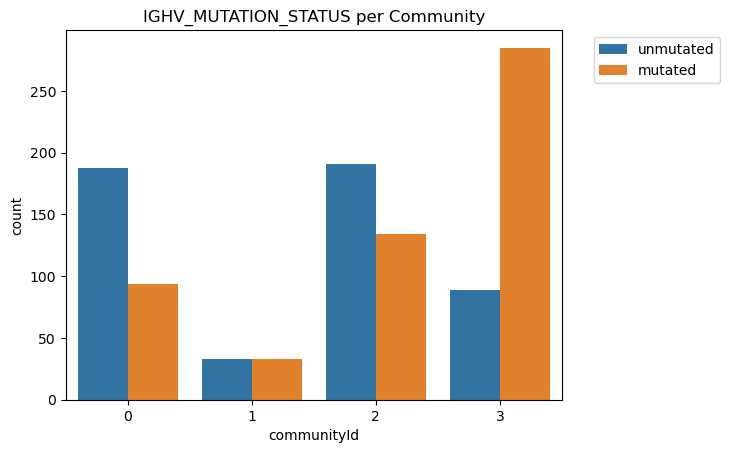

In [37]:
clinical_features = ['IGLV3_21_R110','U1_STATUS', 'EXPRESSION_CLUSTER', 'IGHV_MUTATION_STATUS']
clinical_summary(merged_df, clinical_features)


🔬 COHORT distribution per community:

COHORT           DFCI    GCLLSG      ICGC     MDACC     NHLBI      UCSD
communityId                                                            
0            0.090909  0.314685  0.496503  0.031469  0.041958  0.024476
1            0.469697  0.000000  0.303030  0.000000  0.075758  0.151515
2            0.166163  0.311178  0.323263  0.024169  0.148036  0.027190
3            0.226913  0.224274  0.511873  0.013193  0.018470  0.005277


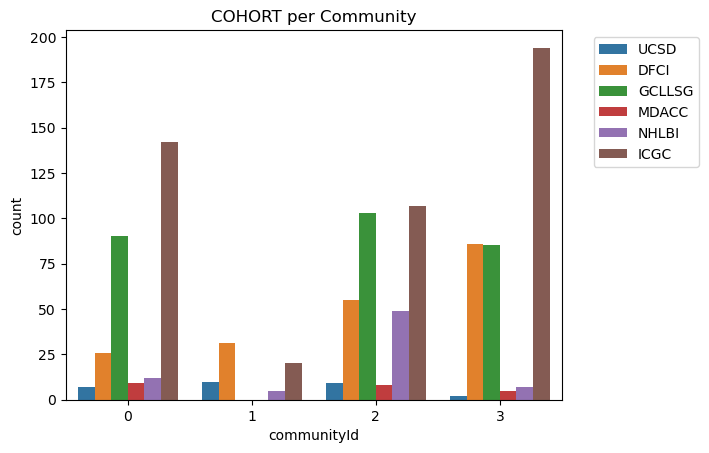


🔬 originId distribution per community:

originId            1         2         3         4         5         6  \
communityId                                                               
0            0.496503  0.024476  0.010490  0.010490  0.080420  0.314685   
1            0.303030  0.151515  0.045455  0.075758  0.424242  0.000000   
2            0.323263  0.027190  0.021148  0.045317  0.145015  0.311178   
3            0.511873  0.005277  0.036939  0.005277  0.189974  0.224274   

originId            8         9  
communityId                      
0            0.031469  0.031469  
1            0.000000  0.000000  
2            0.102719  0.024169  
3            0.013193  0.013193  


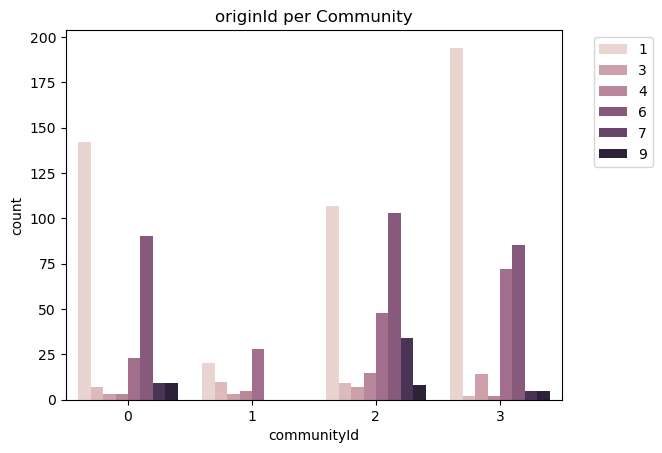


🔬 originType distribution per community:

originType   PUBLICATION     TRIAL
communityId                       
0               0.622378  0.377622
1               1.000000  0.000000
2               0.561934  0.438066
3               0.749340  0.250660


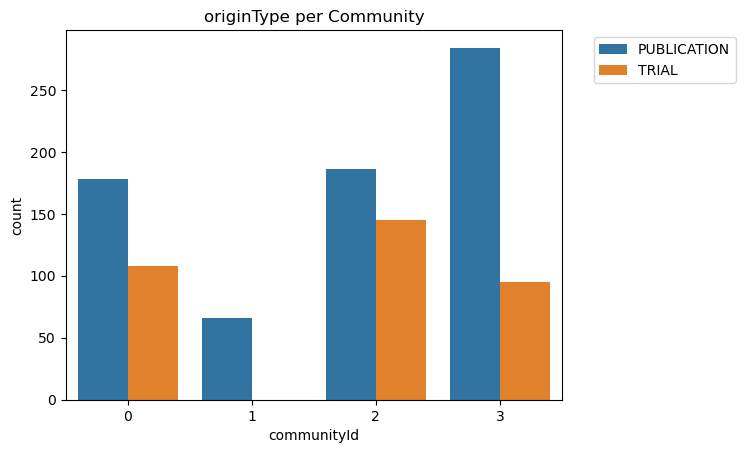

In [38]:
clinical_features = ['COHORT','originId', 'originType']
clinical_summary(merged_df, clinical_features)

In [39]:
# 📌 SECTION 5B: CLINICAL NUMERIC ATTRIBUTES
def clinical_numeric_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(df.groupby(groupby)[feat].describe())

        sns.boxplot(data=df, x=groupby, y=feat)
        plt.title(f"{feat} Distribution per Community")
        plt.show()


🔬 MUTATION_COUNT distribution per community:

             count       mean        std  min   25%   50%    75%    max
communityId                                                            
0            255.0  34.835294  31.734819  7.0  21.0  29.0  40.00  320.0
1             63.0  42.587302  79.898451  4.0  18.5  26.0  36.00  556.0
2            312.0  29.554487  23.977822  4.0  19.0  25.0  32.25  310.0
3            344.0  26.718023  24.063306  4.0  17.0  23.0  30.00  331.0


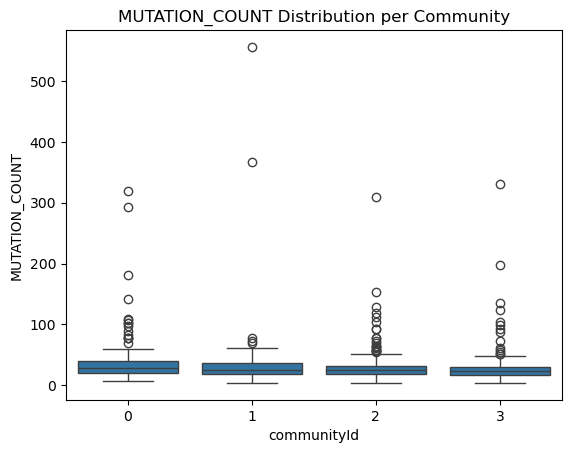


🔬 TMB_NONSYNONYMOUS distribution per community:

             count      mean       std       min       25%       50%  \
communityId                                                            
0            255.0  1.160000  1.058203  0.233333  0.700000  0.966667   
1             63.0  1.421693  2.671039  0.133333  0.616667  0.866667   
2            312.0  0.984936  0.799507  0.133333  0.633333  0.833333   
3            344.0  0.890213  0.802085  0.133333  0.566667  0.766667   

                  75%        max  
communityId                       
0            1.333333  10.666667  
1            1.200000  18.566667  
2            1.100000  10.333333  
3            1.000000  11.033333  


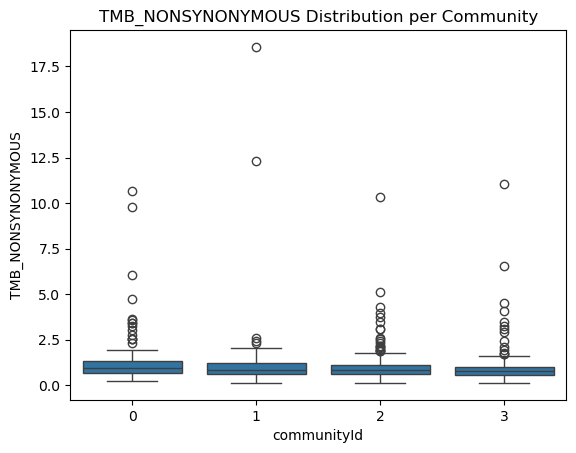


🔬 IGHV_IDENTITY_PERCENTAGE distribution per community:

             count       mean       std    min      25%      50%     75%  \
communityId                                                                
0            282.0  97.814504  3.309228  87.50  95.8300  100.000  100.00   
1             66.0  96.951061  3.475342  88.89  95.3575   98.090  100.00   
2            322.0  97.416770  3.503677  84.72  95.5125   99.615  100.00   
3            374.0  95.265722  3.407303  85.26  92.7100   95.490   97.92   

               max  
communityId         
0            100.0  
1            100.0  
2            100.0  
3            100.0  


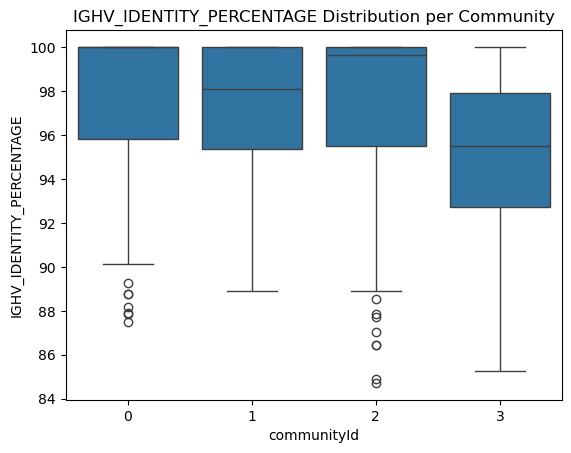

In [40]:
clinical_numeric_features = ['MUTATION_COUNT', 'TMB_NONSYNONYMOUS', 'IGHV_IDENTITY_PERCENTAGE']
clinical_numeric_summary(merged_df, clinical_numeric_features)

In [41]:
mutation_annotated = (
    mutation_df.merge(community_df, on='patientId')
    .drop_duplicates(subset=['patientId', 'communityId', 'hugoGeneSymbol'])
    .assign(has_mutation=1)
    # Now each row = patient, community, gene (unique), has_mutation=1
    # This is suitable for patient-level summaries
    # For other features, drop_duplicates on patientId, communityId, feature as needed
    # For gene-level, use hugoGeneSymbol
    # For other columns, adapt as needed
    # For patient-level summaries, groupby patientId, communityId, hugoGeneSymbol
    # For community-level, groupby communityId, hugoGeneSymbol
    # For top-N, count unique patients per gene per community
    # For plotting, use n_patients/total_patients per community
    # For other features, adapt as above
    )

In [42]:
# 📌 SECTION 6: MUTATION ENRICHMENT ANALYSIS (Patient-level)

def mutation_enrichment(mutation_annotated, community_df, top_n_genes=20):
    # For each community and gene, count unique patients with at least one mutation
    gene_patient_counts = mutation_annotated.groupby(['communityId', 'hugoGeneSymbol'])['patientId'].nunique().unstack(fill_value=0)
    # Find top N most mutated genes overall (by unique patient count)
    top_genes = gene_patient_counts.sum(axis=0).sort_values(ascending=False).head(top_n_genes).index
    gene_counts_top = gene_patient_counts[top_genes]
    # For each community, get total unique patients
    comm_patient_counts = mutation_annotated.groupby('communityId')['patientId'].nunique()
    gene_fraction = gene_counts_top.div(comm_patient_counts, axis=0)
    sns.heatmap(gene_fraction.T, cbar_kws={'label': 'Fraction of Patients'})
    plt.title(f"Top {top_n_genes} Gene Mutation Enrichment per Community (Patient-level)")
    plt.xlabel("Community")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()

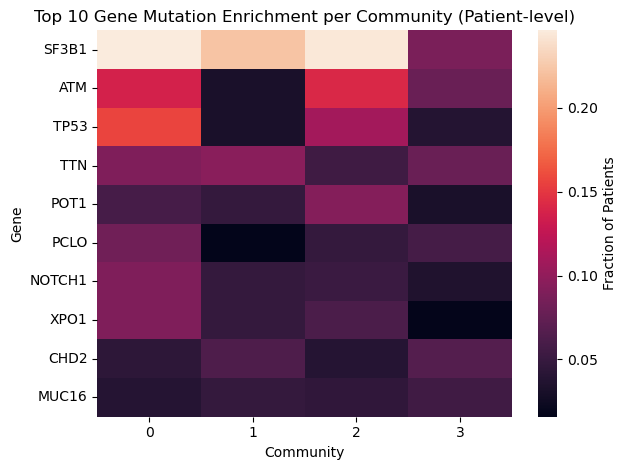

In [43]:
mutation_enrichment(mutation_annotated, community_df, top_n_genes=10)

In [44]:
# 📌 SECTION 6C: PLOT CATEGORICAL FEATURES (≤10 unique values, Patient-level)
def plot_small_categoricals(df, features, groupby='communityId'):
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for feat in features:
        if df[feat].nunique() <= 10:
            print(f"\n🔹 Distribution of '{feat}' across communities (fraction of patients):")
            # For each community and value, count unique patients
            ct = df.groupby([groupby, feat])['patientId'].nunique().unstack(fill_value=0)
            ct_frac = ct.div(comm_patient_counts, axis=0)
            display(ct_frac.style.format("{:.2%}"))
            ct_frac.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,5))
            plt.title(f"{feat} Distribution by Community (Patient-level)")
            plt.ylabel("Fraction of Patients")
            plt.xlabel("Community")
            plt.legend(title=feat, bbox_to_anchor=(1.05, 1), loc='upper left')
            # annotate percentage on bars
            plt.tight_layout()
            plt.show()



🔹 Distribution of 'mutationType' across communities (fraction of patients):


mutationType,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Region,Splice_Site,Translation_Start_Site
communityId,,,,,,,,,,
0,53.91%,23.05%,18.36%,2.73%,100.00%,75.39%,3.52%,31.25%,48.44%,5.47%
1,38.10%,20.63%,15.87%,0.00%,100.00%,73.02%,6.35%,28.57%,46.03%,0.00%
2,46.79%,20.19%,17.63%,0.96%,100.00%,73.40%,3.85%,20.83%,44.55%,2.24%
3,41.57%,15.99%,13.66%,1.45%,100.00%,68.60%,3.78%,20.35%,39.24%,3.20%


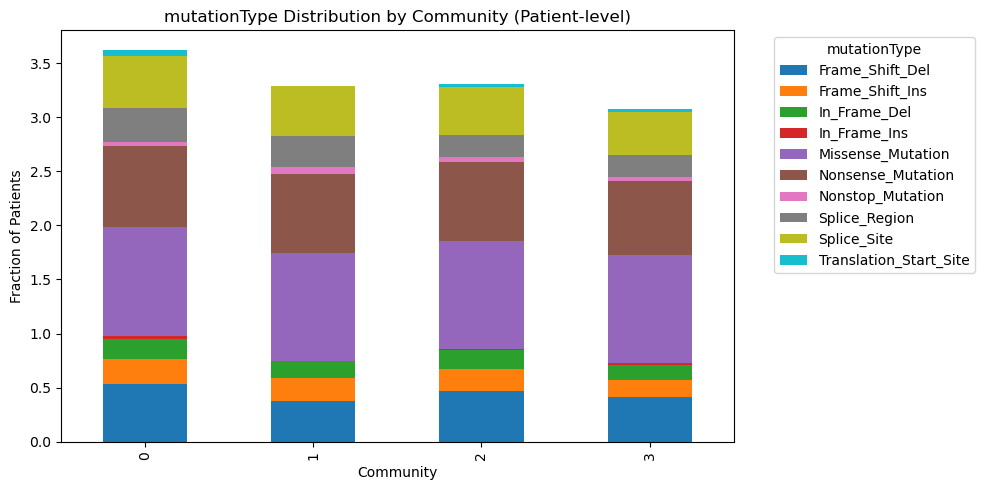


🔹 Distribution of 'variantType' across communities (fraction of patients):


variantType,DEL,INS,SNP
communityId,,,
0,64.06%,25.78%,100.00%
1,46.03%,22.22%,100.00%
2,55.77%,23.40%,100.00%
3,49.13%,18.31%,100.00%


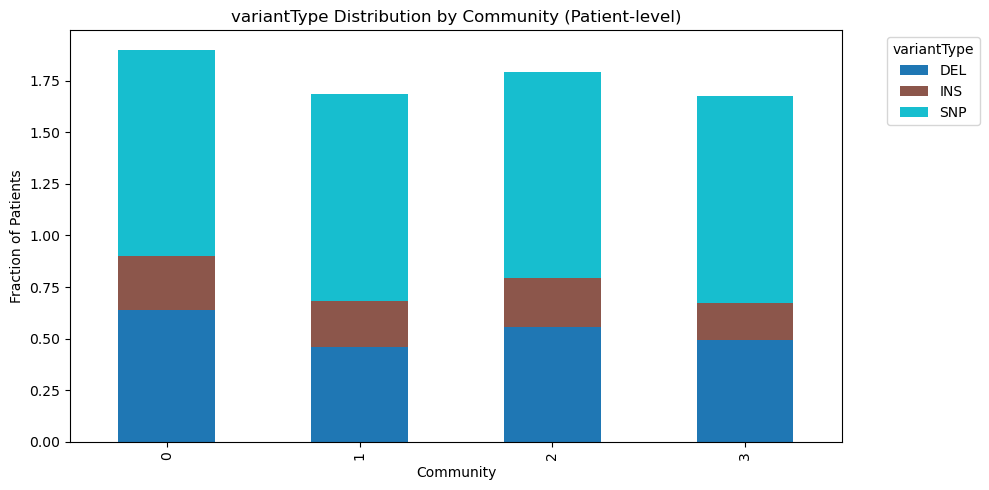

In [45]:
small_categorical_features = ['mutationType', 'variantType']
plot_small_categoricals(mutation_annotated, small_categorical_features)

In [46]:
# 📌 SECTION 6D: TOP-5 HIGH CARDINALITY CATEGORICAL FEATURES (Patient-level Percentages)
def top_values_by_community(df, col, groupby='communityId', top_n=5):
    print(f"\n🔎 Top {top_n} values of '{col}' per community (percentage of patients with at least one {col}):")
    
    rows = []
    plot_data = []
    # For each community, get total unique patients
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for cid, sub in df.groupby(groupby):
        total_patients = comm_patient_counts[cid]
        # For each value, count unique patients with at least one occurrence
        val_patient_counts = sub.groupby(col)['patientId'].nunique().sort_values(ascending=False).head(top_n)
        for val, n_patients in val_patient_counts.items():
            pct = 100 * n_patients / total_patients if total_patients > 0 else 0
            rows.append({'Community': cid, col: val, 'Percentage': round(pct, 2)})
            plot_data.append({'Community': cid, col: val, 'Percentage': pct})
    
    # Table: Top N per community, percentage of patients
    summary_df = pd.DataFrame(rows)
    display(summary_df.pivot(index='Community', columns=col, values='Percentage').fillna(0))
    
    # Plot: Stacked bar, only top N per community, percentage of patients
    plot_df = pd.DataFrame(plot_data)
    pivot = plot_df.pivot(index='Community', columns=col, values='Percentage').fillna(0)
    ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
    plt.title(f"Top {top_n} '{col}' values by Community (Percent of Patients)")
    plt.ylabel("% of Patients in Community")
    plt.xlabel("Community")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Annotate percentages on bars
    for i, (idx, row) in enumerate(pivot.iterrows()):
        cumm = 0
        for j, val in enumerate(row):
            if val > 0:
                plt.text(i, cumm + val/2, f"{val:.1f}%", ha='center', va='center', fontsize=9)
                cumm += val
    plt.show()


🔎 Top 5 values of 'hugoGeneSymbol' per community (percentage of patients with at least one hugoGeneSymbol):


hugoGeneSymbol,ATM,CHD2,CSMD1,CSMD3,NOTCH1,PCLO,POT1,SF3B1,TP53,TTN,XPO1,ZMYM3
Community,,,,,,,,,,,,
0,13.67,0.00,0.00,0.00,8.98,0.00,0.00,24.61,15.62,8.98,0.00,0.00
1,0.00,0.00,7.94,7.94,0.00,0.00,0.00,22.22,0.00,9.52,0.00,7.94
2,14.10,0.00,0.00,0.00,0.00,0.00,9.29,24.36,10.90,0.00,6.09,0.00
3,7.85,6.69,0.00,0.00,0.00,5.81,0.00,8.72,0.00,7.85,0.00,0.00


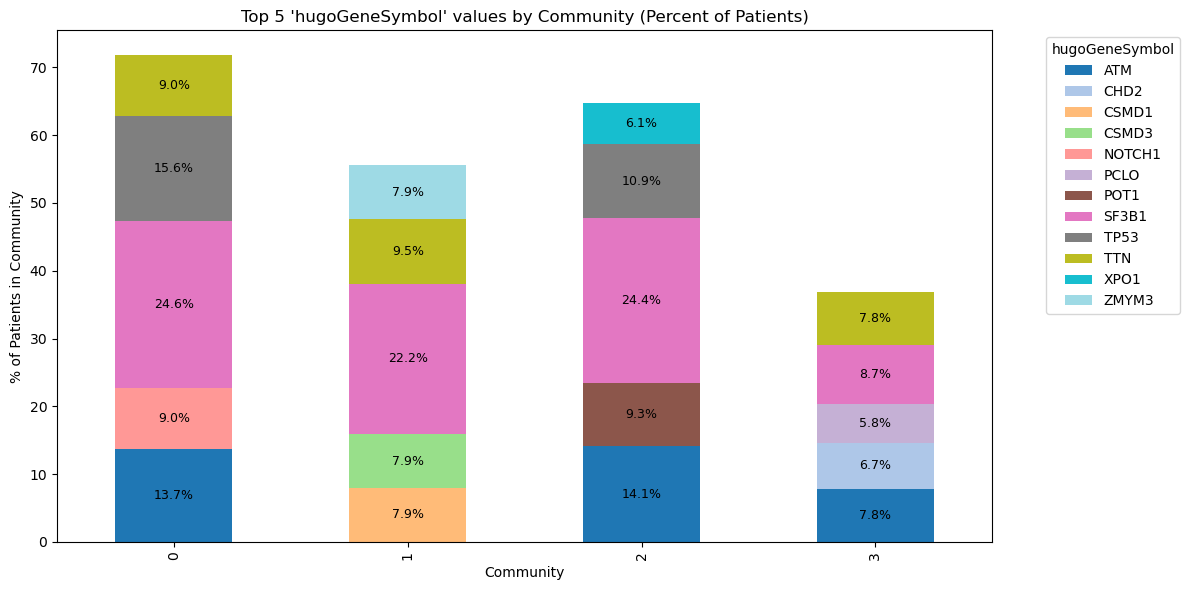


🔎 Top 5 values of 'proteinChange' per community (percentage of patients with at least one proteinChange):


proteinChange,E571K,G109R,G234R,G742D,K700E,L265P,L65P,M1?,P2514Rfs*4,X102_splice
Community,,,,,,,,,,
0,5.86,0.00,0.00,4.30,8.98,0.00,0.00,5.47,6.64,0.00
1,0.00,0.00,4.76,4.76,9.52,4.76,0.00,0.00,0.00,4.76
2,3.21,3.53,0.00,3.85,12.50,0.00,0.00,0.00,2.88,0.00
3,0.00,0.00,0.00,0.00,3.49,4.07,1.74,3.20,1.74,0.00


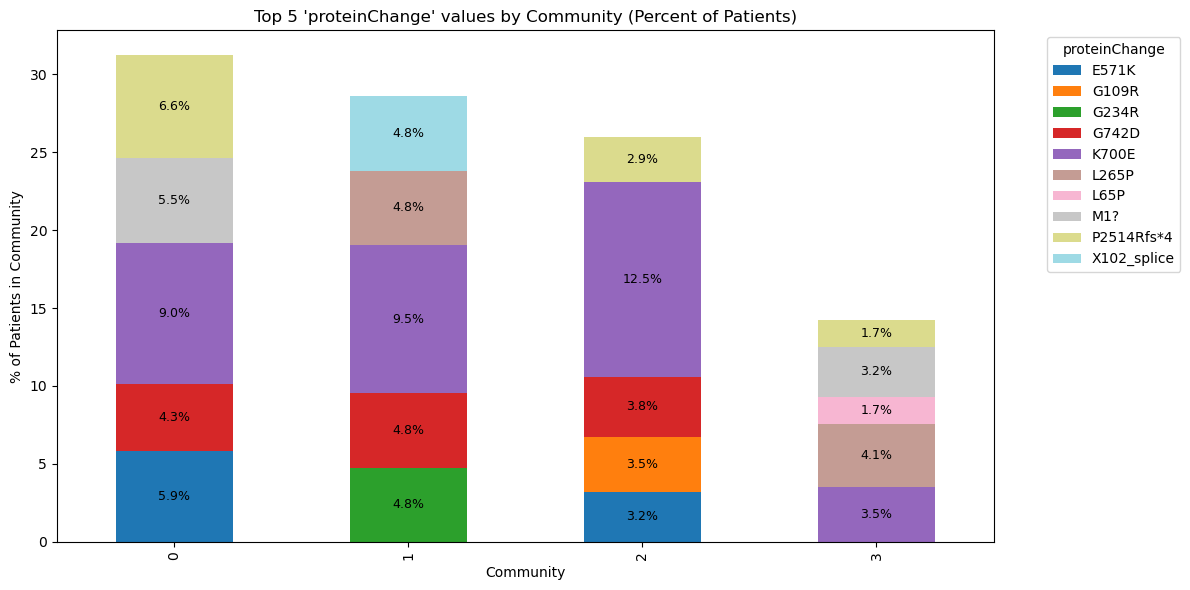


🔎 Top 5 values of 'referenceAllele' per community (percentage of patients with at least one referenceAllele):


referenceAllele,-,A,C,G,T
Community,,,,,
0,25.78,95.70,100.00,100.00,95.31
1,22.22,95.24,98.41,98.41,98.41
2,23.40,95.83,100.00,99.36,94.55
3,18.31,93.90,99.71,100.00,95.06


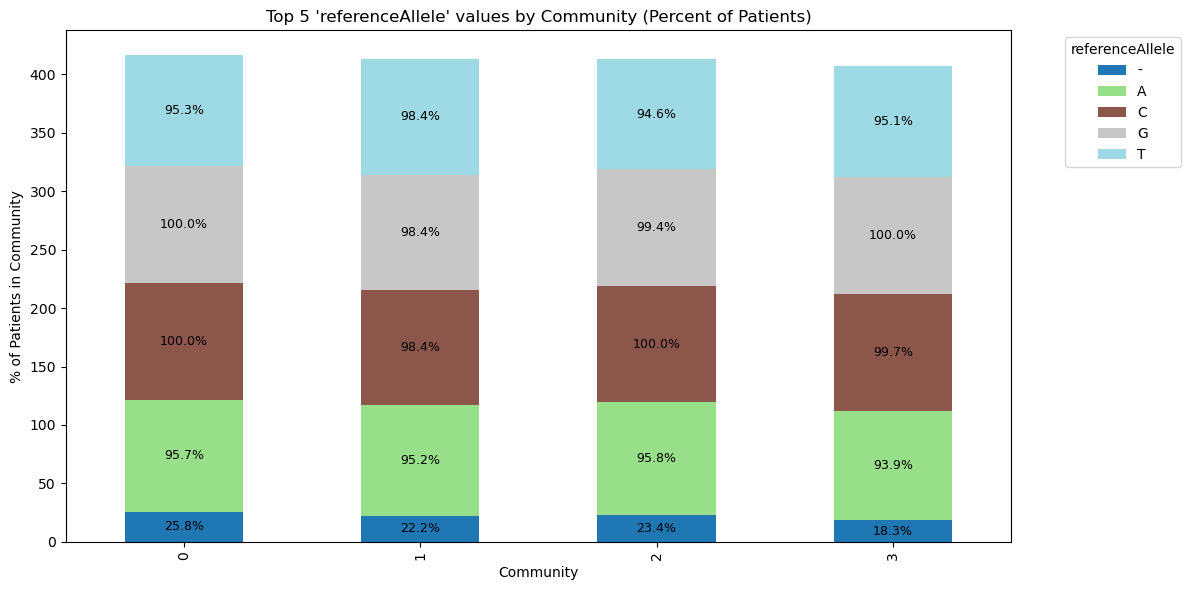


🔎 Top 5 values of 'variantAllele' per community (percentage of patients with at least one variantAllele):


variantAllele,-,A,C,G,T
Community,,,,,
0,64.06,100.00,94.53,95.31,100.00
1,46.03,100.00,100.00,95.24,100.00
2,55.77,100.00,94.23,92.31,100.00
3,49.13,99.71,96.22,93.31,99.13


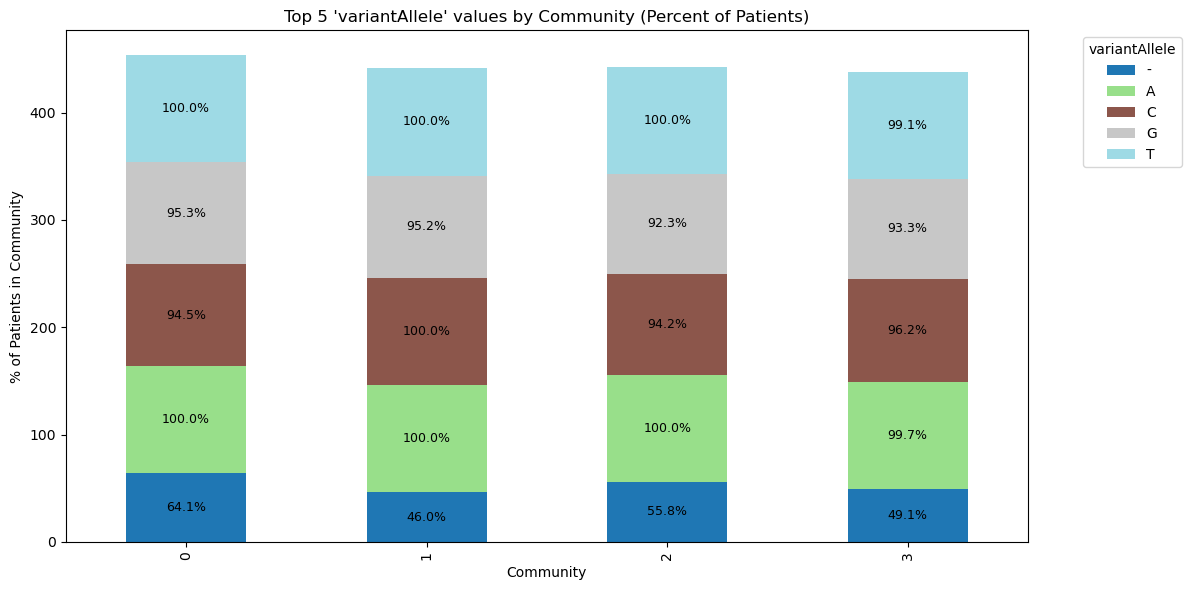

In [47]:
columns_to_analyze = [
    'hugoGeneSymbol', 'proteinChange', 'referenceAllele', 'variantAllele'
    # Add more columns as needed
]
for col in columns_to_analyze:
    top_values_by_community(mutation_annotated, col)  # Patient-level analysis

In [48]:
# 📌 SECTION 6E: NUMERICAL SUMMARY (tumorAltCount, tumorRefCount)
def numeric_distribution_by_community(df, numeric_cols, groupby='communityId'):
    for col in numeric_cols:
        print(f"\n📊 Summary statistics for {col}:")
        display(df.groupby(groupby)[col].describe())

        sns.boxplot(data=df, x=groupby, y=col)
        plt.title(f"{col} Distribution by Community")
        plt.tight_layout()
        plt.show()


📊 Summary statistics for tumorAltCount:


,count,mean,std,min,25%,50%,75%,max
communityId,,,,,,,,
0,8781.0,17.804692,28.091220,2.0,4.0,6.0,20.0,731.0
1,2607.0,14.490986,26.963930,0.0,3.0,5.0,12.0,417.0
2,9070.0,19.840684,29.518443,0.0,4.0,8.0,24.0,511.0
3,9068.0,18.071129,26.235823,2.0,4.0,7.0,22.0,452.0


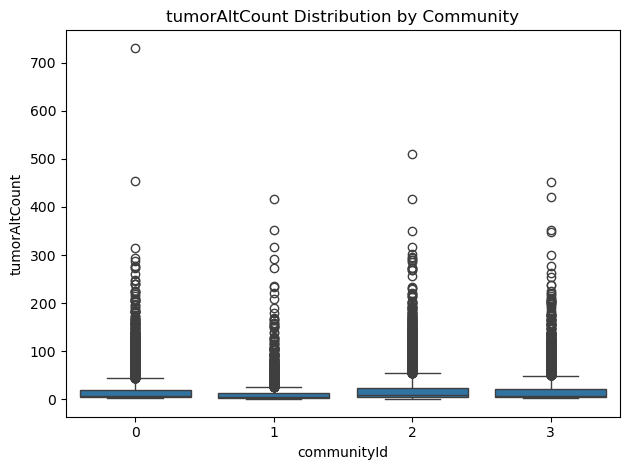


📊 Summary statistics for tumorRefCount:


,count,mean,std,min,25%,50%,75%,max
communityId,,,,,,,,
0,8781.0,97.407812,100.583498,0.0,34.0,67.0,124.0,1856.0
1,2607.0,116.770618,120.082555,0.0,43.0,81.0,142.5,1067.0
2,9070.0,104.513892,109.636894,0.0,38.0,74.0,134.0,1525.0
3,9068.0,89.306131,111.017829,0.0,32.0,60.0,109.0,2883.0


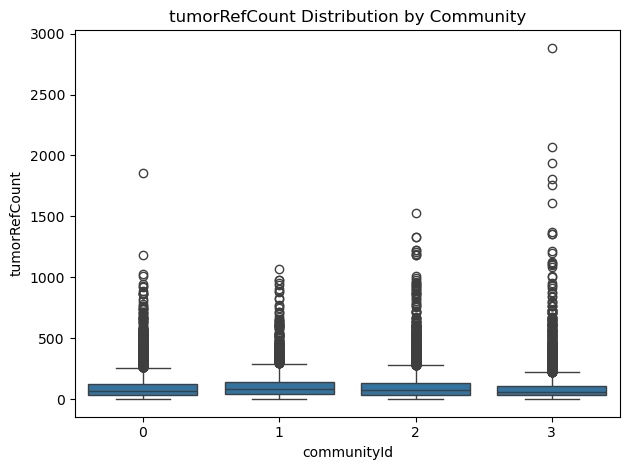

In [49]:
columns_to_analyze = ['tumorAltCount', 'tumorRefCount']
numeric_distribution_by_community(mutation_annotated, columns_to_analyze)

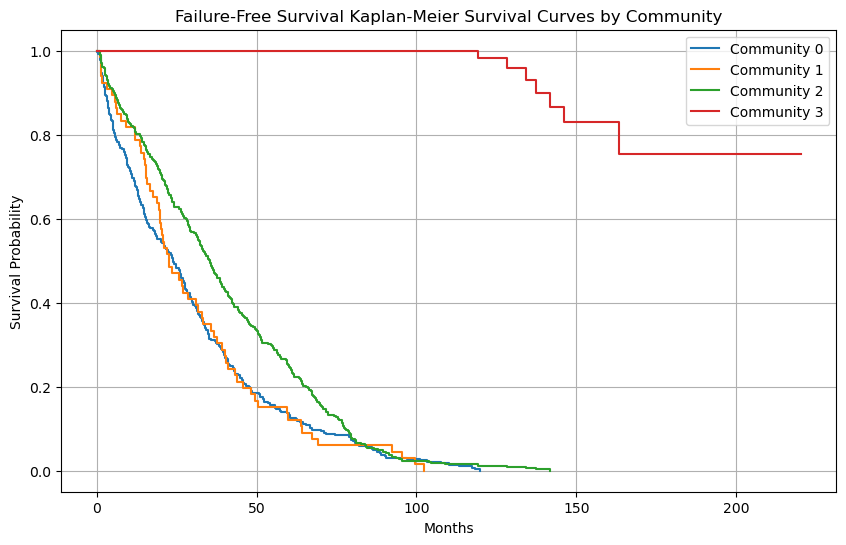

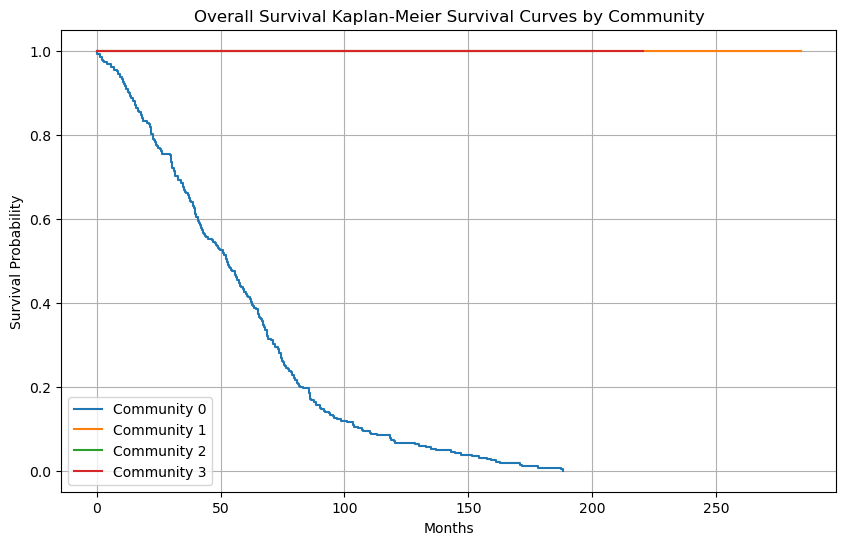

In [56]:
# 📌 SECTION 7: SURVIVAL ANALYSIS
def survival_km(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10,6))
    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col], label=f"Community {name}")
        kmf.plot_survival_function(ci_show=False)
    plt.title(f"{label} Kaplan-Meier Survival Curves by Community")
    plt.xlabel("Months")
    plt.ylabel("Survival Probability")
    plt.grid(True)
    if time_col == 'FFS_MONTHS':
        plt.savefig("../../figures/survival_curves.png", dpi = 300)
    plt.show()

# Convert FFS_STATUS and OS_STATUS to binary event columns
merged_df['FFS_STATUS_EVENT'] = merged_df['FFS_STATUS'].str.startswith('1:').astype(int)
merged_df['OS_STATUS_EVENT'] = merged_df['OS_STATUS'].str.startswith('1:').astype(int)

survival_km(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
survival_km(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

In [51]:
# 📌 SECTION 8: STATISTICAL TESTS
def run_statistical_tests(df, groupby='communityId'):
    print("\n📊 Kruskal-Wallis Test for AGE_SAMPLING:")
    groups = [group['AGE_SAMPLING'].dropna() for _, group in df.groupby(groupby)]
    print(kruskal(*groups))

    for feat in ['SEX', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE']:
        print(f"\n📊 Chi-square Test for {feat}:")
        contingency = pd.crosstab(df[groupby], df[feat])
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}")

run_statistical_tests(merged_df)


📊 Kruskal-Wallis Test for AGE_SAMPLING:
KruskalResult(statistic=np.float64(32.95858788276993), pvalue=np.float64(3.286106602716904e-07))

📊 Chi-square Test for SEX:
Chi2 = 12.76, p-value = 0.0052

📊 Chi-square Test for CLL_EPITYPE:
Chi2 = 169.44, p-value = 0.0000

📊 Chi-square Test for TUMOR_MOLECULAR_SUBTYPE:
Chi2 = 10.90, p-value = 0.0123


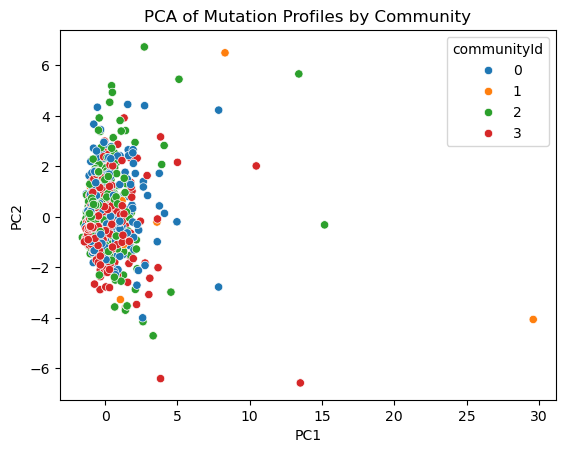

In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns

# Subset features (e.g., top 50 genes across all patients)
# pivot: patients x genes (1 if mutated, 0 otherwise)
mut = mutation_df.copy()
mut['mut_flag'] = 1
mut_matrix = mut.pivot_table(index='patientId', columns='hugoGeneSymbol', values='mut_flag', fill_value=0)

# Filter top 100 mutated genes
top_genes = mut['hugoGeneSymbol'].value_counts().head(100).index
mut_matrix = mut_matrix[top_genes.intersection(mut_matrix.columns)]

# Merge with community labels
feat_df = pd.merge(mut_matrix.reset_index(), community_df, on='patientId')

# Standardize and reduce
X = StandardScaler().fit_transform(feat_df[top_genes])
pca = PCA(n_components=2).fit_transform(X)
feat_df['PC1'], feat_df['PC2'] = pca[:,0], pca[:,1]

sns.scatterplot(data=feat_df, x='PC1', y='PC2', hue='communityId', palette='tab10')
plt.title("PCA of Mutation Profiles by Community")
plt.show()


In [53]:
# pip install gseapy
import gseapy as gp

gene_list = list(mut_matrix.columns[mut_matrix.sum() > 10])  # example threshold
enr = gp.enrichr(gene_list=gene_list, gene_sets='KEGG_2021_Human', outdir=None)
enr.results[['Term', 'Adjusted P-value', 'Overlap']]


,Term,Adjusted P-value,Overlap
0,Thyroid cancer,0.000090,5/37
1,Hepatitis B,0.000090,8/162
2,Bladder cancer,0.000090,5/41
3,Chronic myeloid leukemia,0.000090,6/76
4,Endometrial cancer,0.000337,5/58
...,...,...,...
158,Neutrophil extracellular trap formation,0.629424,1/189
159,Pathogenic Escherichia coli infection,0.641095,1/197
160,Diabetic cardiomyopathy,0.648343,1/203
161,Coronavirus disease,0.693794,1/232


## Visualisation

In [54]:
# get nodes table with community assignments and edges table with source, target, weight
from collections import Counter, defaultdict

# Step 1: Build mapping from patientId to all their communities
patient_to_comms = defaultdict(set)
for _, row in community_df.iterrows():
    patient_to_comms[row['patientId']].add(row['communityId'])

# Step 2: Assign new community IDs for overlaps
overlap_map = {}  # tuple of communities -> new communityId
next_overlap_id = max(community_df['communityId'].max() + 1, 4)  # start from 4 or next available

node_rows = []
for pid, comms in patient_to_comms.items():
    comms_tuple = tuple(sorted(comms))
    if len(comms_tuple) == 1:
        # Single community, keep as is
        node_rows.append({'nodeId': pid, 'communityId': comms_tuple[0]})
    else:
        # Overlapping, assign new communityId
        if comms_tuple not in overlap_map:
            overlap_map[comms_tuple] = next_overlap_id
            next_overlap_id += 1
        node_rows.append({'nodeId': pid, 'communityId': overlap_map[comms_tuple]})

nodes_df = pd.DataFrame(node_rows)

# Map patientId to nodeId using mapping_df as before
G = nx.read_gml(os.path.join(base_path, "graph.gml"), label='id')
mapping_df = pd.read_csv(os.path.join(base_path, "patient_id_mapping.csv"))
mapping_df['nodeId'] = mapping_df['nodeId'].astype(int)
mapping_dict = mapping_df.set_index('patientId')['nodeId'].to_dict()
nodes_df['Id'] = nodes_df['nodeId'].map(mapping_dict)

# Remove any rows with missing nodeId (if mapping is incomplete)
nodes_df = nodes_df.dropna(subset=['Id'])
nodes_df.drop(columns='nodeId', inplace=True)  # keep only Id and communityId

# Edges as before
edges_df = pd.DataFrame(G.edges(data=True), columns=['source', 'target', 'data'])
edges_df['weight'] = edges_df['data'].apply(lambda x: x.get('weight', 1))  # default weight to 1 if not present
edges_df.drop(columns='data', inplace=True)

# Save nodes and edges to CSV for visualization
nodes_df.to_csv(os.path.join(base_path, algo, 'nodes.csv'), index=False)
edges_df.to_csv(os.path.join(base_path, algo, 'edges.csv'), index=False)

# Print mapping of overlaps for reference
print("Overlap group mapping (tuple of original communities -> new communityId):")
for k, v in overlap_map.items():
    print(f"{k} -> {v}")

Overlap group mapping (tuple of original communities -> new communityId):
(1, 2) -> 4
(2, 3) -> 5
